## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image
from copy import deepcopy


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from utils import *

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance 
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression


import warnings
warnings.filterwarnings('ignore')




# Part 1

## Load Data

In [2]:
# Data paths
labeled_data_path = '../data/data_labeled/'
unlabeled_data_path = '../data/data_unlabeled/'

# Image paths
img_test_unlabeled_path = '../data/data_labeled/Img_test/'
img_train_unlabeled_path = '../data/data_labeled/Img_train/'
X_img_path = '../data/data_unlabeled/Img/'

# Load csv's
X_test = pd.read_csv(labeled_data_path + 'X_test.csv')
X_train = pd.read_csv(labeled_data_path + 'X_train.csv')
y_test = pd.read_csv(labeled_data_path + 'y_test.csv', header=None)
y_train = pd.read_csv(labeled_data_path + 'y_train.csv', header=None)
X_unlabeled = pd.read_csv(unlabeled_data_path + 'X.csv')

X_test.head()

,age,blood pressure,calcium,cholesterol,hemoglobin,height,potassium,profession,sarsaparilla,smurfberry liquor,smurfin donuts,vitamin D,weight,img_filename
0,85,106.92,2.25,120.85,14.90,7.41,3.26,resource extraction,Low,High,Moderate,36.27,93.20,heart_0.png
1,130,94.73,2.61,121.74,16.88,7.53,4.74,manufacturing,Very high,Very high,Moderate,25.97,105.24,heart_6.png
2,180,110.31,2.47,75.35,15.52,8.02,4.29,manufacturing,High,Moderate,Very low,37.53,100.61,heart_7.png
3,78,95.46,2.28,125.30,11.68,7.75,4.17,services,Very low,Low,Moderate,28.19,103.94,heart_10.png
4,116,106.13,2.11,89.98,14.83,7.89,4.73,resource extraction,Low,Very high,Low,30.07,82.53,heart_11.png


## Preprocess Data

In [3]:

#Save data before cleaning
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()
X_unlabeled_clean = X_unlabeled.copy()

X_train = X_train.drop(columns=['img_filename'])
X_test = X_test.drop(columns=['img_filename'])
X_unlabeled = X_unlabeled.drop(columns=['img_filename'])

X_train = pd.get_dummies(X_train, columns=['profession'])
X_test = pd.get_dummies(X_test, columns=['profession'])
X_unlabeled = pd.get_dummies(X_unlabeled, columns=['profession'])

# Ordinal encoding of consumption features
consumption_map = {
    'Very low': 1,
    'Low': 2,
    'Moderate': 3,
    'High': 4,
    'Very high': 5
}

for col in ['sarsaparilla', 'smurfberry liquor', 'smurfin donuts']:
    X_train[col] = X_train[col].map(consumption_map)
    X_test[col] = X_test[col].map(consumption_map)
    X_unlabeled[col] = X_unlabeled[col].map(consumption_map)
    
# Standardize numerical features
numerical_features = [
    'age', 'blood pressure', 'calcium', 'cholesterol',
    'hemoglobin', 'height', 'potassium',
    'vitamin D', 'weight'
]

X_train_original = X_train.copy()
X_test_original = X_test.copy()
X_unlabeled_original = X_unlabeled.copy()


## Feature Selection

### Filter

#### Mutual Information

In [4]:

mi_scores = mutual_info_regression(X_train, y_train.values.ravel(), random_state=42)
mi_df = pd.DataFrame({'Feature': X_train.columns, 'MI': mi_scores})
mi_df = mi_df.sort_values(by='MI', ascending=False).reset_index(drop=True)


mean_mi, std_mi = mi_df['MI'].mean(), mi_df['MI'].std()

threshold_soft = mean_mi + 0.3 * std_mi
selected_by_threshold = mi_df[mi_df['MI'] > threshold_soft]['Feature'].tolist()
print(len(selected_by_threshold))
# En cas de peu de sélection, garde toutes les features avec MI > 0
if len(selected_by_threshold) < 6:
    selected_by_threshold = mi_df[mi_df['MI'] > 0]['Feature'].tolist()

print(f"\n Seuil souple = {threshold_soft:.4f}")
print(f"{len(selected_by_threshold)} features retenues après filtrage MI :")
print(selected_by_threshold)

# Sous-ensembles correspondants
selected_features_mi = selected_by_threshold
X_train_mi = X_train[selected_features_mi].copy()
X_test_mi  = X_test[selected_features_mi].copy()
X_unlabeled_mi = X_unlabeled[selected_features_mi].copy()

4

 Seuil souple = 0.0610
14 features retenues après filtrage MI :
['blood pressure', 'cholesterol', 'weight', 'smurfin donuts', 'potassium', 'sarsaparilla', 'vitamin D', 'profession_administration and governance', 'age', 'hemoglobin', 'profession_services', 'profession_food production', 'profession_resource extraction', 'profession_manufacturing']


#### Maximum relevance and minimum redundancy

In [5]:
corr_matrix = X_train_mi.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [col for col in upper.columns if any(upper[col] > 0.85)]
X_train_mrmr = X_train_mi.drop(columns=high_corr, errors='ignore')
#X_val_mrmr = X_val_mi.drop(columns=high_corr, errors='ignore')
X_test_mrmr = X_test_mi.drop(columns=high_corr, errors='ignore')
X_unlabeled_mrmr = X_unlabeled_mi.drop(columns=high_corr, errors='ignore')
y_train_ravel = y_train.values.ravel()
print(f"\n{len(high_corr)} variables redondantes supprimées après mRMR simplifié :")
print(high_corr)
print(f"{X_train_mrmr.shape[1]} features restantes après mRMR.")


0 variables redondantes supprimées après mRMR simplifié :
[]
14 features restantes après mRMR.


#### RF selection

In [6]:

rf_selector = RandomForestRegressor(n_estimators=100, random_state =42, n_jobs=-1)
rf_selector.fit(X_train_mrmr, y_train_ravel)

importances = rf_selector.feature_importances_
feature_names = X_train_mrmr.columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 des caractéristiques selon Random Forest Importance:")
print(feature_importances_df.head(10))


Top 10 des caractéristiques selon Random Forest Importance:
                           Feature  Importance
0                   blood pressure    0.581197
9                       hemoglobin    0.117307
4                        potassium    0.098481
2                           weight    0.044934
8                              age    0.043431
1                      cholesterol    0.039196
6                        vitamin D    0.027567
5                     sarsaparilla    0.019582
3                   smurfin donuts    0.010945
12  profession_resource extraction    0.004388


In [7]:


linreg_final = LinearRegression()
linreg_final.fit(X_train_mrmr, y_train)

y_pred_test = linreg_final.predict(X_test_mrmr)
rmse_test_linear = compute_rmse(y_pred_test, y_test)
print(f"\nRMSE sur test = {rmse_test_linear:.4f}")

# Prédictions
y_pred_unlabeled = linreg_final.predict(X_unlabeled_mrmr)


print("\nFichier y_pred.csv généré avec succès !")


RMSE sur test = 0.0571

Fichier y_pred.csv généré avec succès !


# Part 2

In [8]:
rmse_scorer_for_rfecv = make_scorer(compute_rmse, greater_is_better=False)
rf_estimator = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
print("Début de la sélection de caractéristiques RFECV (Cross-Validation) en utilisant la RMSE...")
rfecv_selector = RFECV(
    estimator=rf_estimator,
    step=1,
    cv=5,                             # Utilise 5 plis de Cross-Validation
    scoring=rmse_scorer_for_rfecv,    # Utilisation de votre RMSE scorer
    n_jobs=-1,
    verbose=1
)
rfecv_selector.fit(X_train_mrmr, y_train_ravel)

N_optimal = rfecv_selector.n_features_
print(f"\nNombre optimal de caractéristiques (N) déterminé par CV : {N_optimal}")
selected_features_rfecv = X_train_mrmr.columns[rfecv_selector.support_].tolist()
print("\nCaractéristiques sélectionnées :")
print(selected_features_rfecv)

X_train_part2 = X_train_mrmr[selected_features_rfecv].copy()
X_test_part2 = X_test_mrmr[selected_features_rfecv].copy()

Début de la sélection de caractéristiques RFECV (Cross-Validation) en utilisant la RMSE...
Fitting estimator with 14 features.
Fitting estimator with 14 features.
Fitting estimator with 14 features.
Fitting estimator with 14 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 13 features.
Fitting estimator with 13 features.
Fitting estimator with 13 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting e

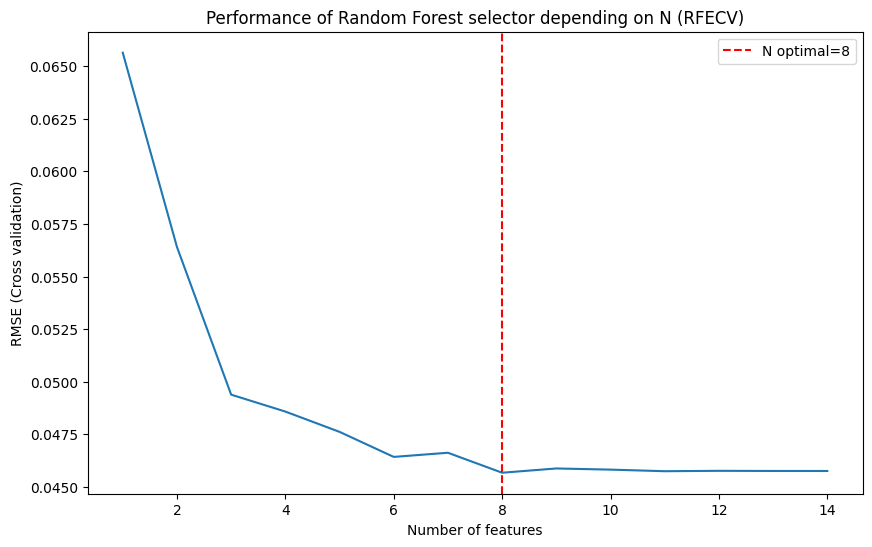

In [9]:

# Assuming it returns the actual RMSE values (since greater_is_better=False)
scores_rmse = -rfecv_selector.cv_results_['mean_test_score'] 
n_features_range = range(1, len(X_train_mrmr.columns) + 1)

# Création du graphique (nécessite matplotlib)
plt.figure(figsize=(10, 6))
plt.plot(n_features_range, scores_rmse)
plt.xlabel("Number of features")
plt.ylabel("RMSE (Cross validation)")
plt.title("Performance of Random Forest selector depending on N (RFECV)")
plt.axvline(x=N_optimal, color='r', linestyle='--', label=f'N optimal={N_optimal}')
plt.legend()
#plt.savefig("C:/Users/User/Desktop/GBIOM2/LELEC2870_Machine_learning/LELEC2870-Project/plots/performance_rf_selection.pdf")
plt.show()


--- Optimisation du MLP (Simple) ---

--- Optimisation du Multi-Layer Perceptron (MLP) ---
Début du tuning MLP...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 60), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.1s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 60), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.1s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 60), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.1s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 60), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.1s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(200, 120), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.3s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(200, 120), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.3s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(200, 120), mlp__lea

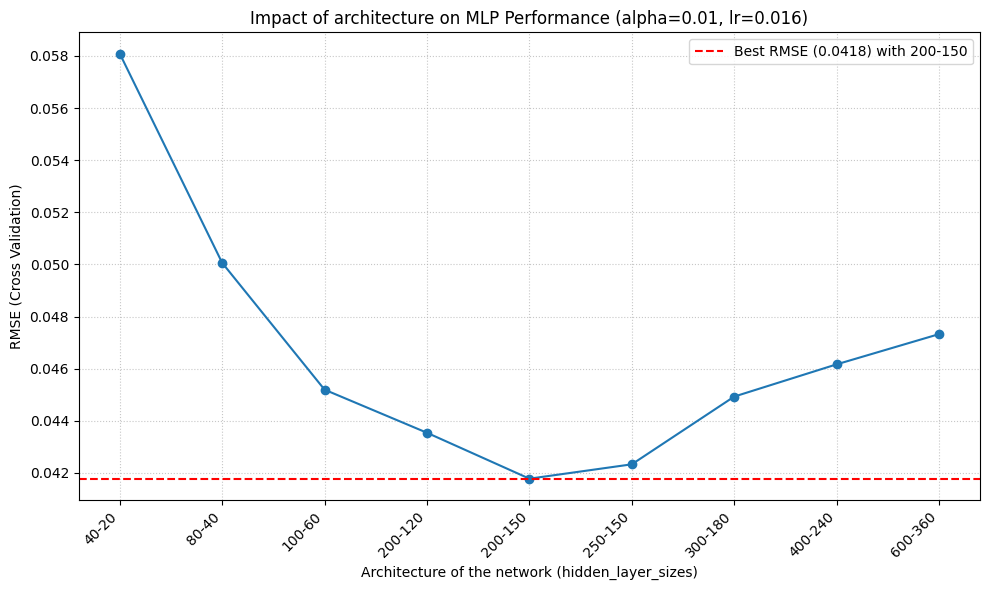

In [10]:
print("\n--- Optimisation du MLP (Simple) ---")

mlp_base_estimator = MLPRegressor(max_iter=500, random_state=42)

# Créer le Pipeline : Scaling puis MLP
pipe_mlp_fine_tune = Pipeline([
    ('scaler', StandardScaler()), 
    ('mlp', mlp_base_estimator) 
])
param_grid_mlp_final = {
    # Architectures à tester :
    # Essayer des configurations à 1 ou 2 couches
    # (40,) : 1 couche de 40 neurones (assez petite pour 12 features)
    # (40, 20) : 2 couches (40 puis 20)
    # (80, 40) : 2 couches plus larges
    'mlp__hidden_layer_sizes': [(40,20), (80, 40), (100, 60), (200, 120),(200,150), (250, 150),(300, 180),(400, 240), (600, 360)], 
    
    # Fonction d'activation (ReLU est standard et performante)
    'mlp__activation': ['relu'],
    
    # Terme de régularisation L2 (alpha)
    # Le MLP est sensible à l'overfitting, donc il faut tester la régularisation
    'mlp__alpha': [0.01],
    
    # Taux d'apprentissage initial
    'mlp__learning_rate_init': [0.016], 
    
    'mlp__solver': ['adam']
}
#Meilleurs hyperparamètres MLP : {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (400, 240), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
# Fixer le nombre maximum d'itérations
# max_iter doit être suffisant pour que le réseau converge (souvent 500 ou 1000)
#mlp_estimator_final = MLPRegressor(max_iter=500, random_state=42)

mlp_grid_final = GridSearchCV(
    estimator=pipe_mlp_fine_tune,
    param_grid=param_grid_mlp_final,
    scoring=rmse_scorer_for_rfecv, # Utilisation du scorer RMSE négatif
    cv=5,
    n_jobs=-1,
    verbose=2
)

print("\n--- Optimisation du Multi-Layer Perceptron (MLP) ---")
print("Début du tuning MLP...")

# Entraînement et tuning sur les 12 caractéristiques
mlp_grid_final.fit(X_train_part2, y_train_ravel) 

# Extraction du résultat RMSE réel (inversion du signe)
best_rmse_val_mlp_final = -mlp_grid_final.best_score_ 

print(f"\nMeilleur RMSE (Validation Croisée MLP) : {best_rmse_val_mlp_final:.4f}")
print(f"Meilleurs hyperparamètres MLP : {mlp_grid_final.best_params_}")

# Sauvegarder le meilleur modèle pour la comparaison finale
best_mlp_model_final = mlp_grid_final.best_estimator_


import pandas as pd


# Assurez-vous d'utiliser l'objet mlp_grid après le fit final
results = pd.DataFrame(mlp_grid_final.cv_results_)

# Création d'une clé d'architecture simple pour le graphique
# Nous allons simplifier l'affichage du tuple (ex: (80, 40) devient '80-40')
def format_architecture(hls_tuple):
    if isinstance(hls_tuple, tuple):
        return '-'.join(map(str, hls_tuple))
    return str(hls_tuple)

results['Architecture_str'] = results['param_mlp__hidden_layer_sizes'].apply(format_architecture)

# Filtrer uniquement les résultats avec les meilleurs autres hyperparamètres 
# (activation='relu', alpha=0.015, learning_rate_init=0.015, solver='adam') 
# pour isoler l'effet de la taille des couches.

best_alpha = mlp_grid_final.best_params_['mlp__alpha']
best_lr = mlp_grid_final.best_params_['mlp__learning_rate_init']

filtered_results = results[
    (results['param_mlp__alpha'] == best_alpha) & 
    (results['param_mlp__learning_rate_init'] == best_lr) &
    (results['param_mlp__activation'] == 'relu') # Si vous n'avez testé que 'relu'
].copy()

# Calcul du RMSE réel (inverser le signe du score CV)
results['RMSE_CV'] = -results['mean_test_score']
plt.figure(figsize=(10, 6))

# Création du graphique : Architecture (X) vs RMSE (Y)
plt.plot(
    results['Architecture_str'], 
    results['RMSE_CV'], 
    marker='o', 
    linestyle='-', 
    color='#1f77b4'
)

# Marquage du meilleur score
min_rmse = results['RMSE_CV'].min()
best_arch = results.loc[results['RMSE_CV'].idxmin(), 'Architecture_str']
plt.axhline(y=min_rmse, color='r', linestyle='--', 
            label=f'Best RMSE ({min_rmse:.4f}) with {best_arch}')

plt.xlabel("Architecture of the network (hidden_layer_sizes)")
plt.ylabel("RMSE (Cross Validation)")
plt.title(f"Impact of architecture on MLP Performance (alpha={best_alpha}, lr={best_lr})")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Le score de généralisation final est du pour le mlp est : 0.0428


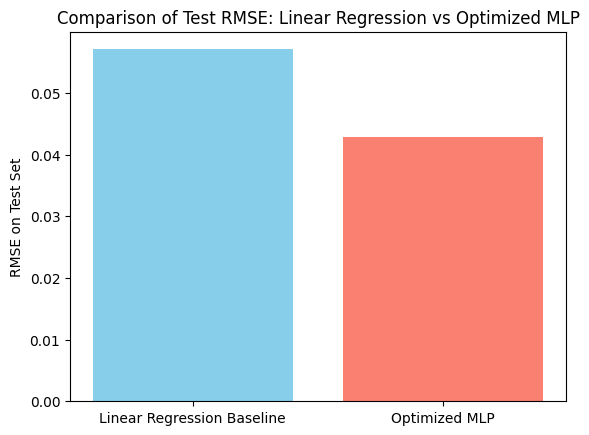

In [11]:

# Prédictions sur l'ensemble de Test
y_test_ravel = y_test.values.ravel() if hasattr(y_test, 'values') else y_test.ravel()
y_pred_test_mlp = best_mlp_model_final.predict(X_test_part2)

# Calcul des RMSE de Test
rmse_test_mlp = compute_rmse(y_pred_test_mlp, y_test_ravel)

# Modèle Linéaire (Baseline - Valeur obtenue en Partie 1)
linearBaseline = rmse_test_linear

# --- 3. Synthèse des Résultats Finals ---

#plot difference in test RMSE
print(f"Le score de généralisation final est du pour le mlp est : {rmse_test_mlp:.4f}")
labels = ['Linear Regression Baseline', 'Optimized MLP']
rmse_values = [linearBaseline, rmse_test_mlp]
plt.bar(labels, rmse_values, color=['skyblue', 'salmon'])
plt.ylabel('RMSE on Test Set')
plt.title('Comparison of Test RMSE: Linear Regression vs Optimized MLP')
plt.show()  

# Part3

Index(['age', 'blood pressure', 'calcium', 'cholesterol', 'hemoglobin',
       'height', 'potassium', 'profession', 'sarsaparilla',
       'smurfberry liquor', 'smurfin donuts', 'vitamin D', 'weight',
       'img_filename'],
      dtype='object')
Train: (1000, 8), Test: (500, 8)
t-SNE on pixel values


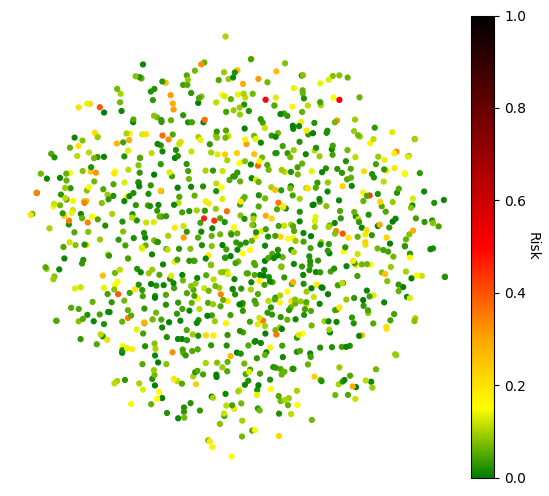

In [12]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)


y_test = pd.read_csv(labeled_data_path + 'y_test.csv', header=None)
y_train = pd.read_csv(labeled_data_path + 'y_train.csv', header=None)

X_train = X_train_clean
X_test = X_test_clean
X_unlabeled = X_unlabeled_clean

print(X_train.columns)
cols = [
    'blood pressure', 'cholesterol', 'weight', 'potassium',
    'sarsaparilla', 'vitamin D', 'age', 'hemoglobin'
]
X_train = pd.get_dummies(X_train, columns=['profession'])
X_test = pd.get_dummies(X_test, columns=['profession'])
X_unlabeled = pd.get_dummies(X_unlabeled, columns=['profession'])
# Ordinal encoding of consumption features
consumption_map = {
    'Very low': 1,
    'Low': 2,
    'Moderate': 3,
    'High': 4,
    'Very high': 5
}

for col in ['sarsaparilla', 'smurfberry liquor', 'smurfin donuts']:
    X_train[col] = X_train[col].map(consumption_map)
    X_test[col] = X_test[col].map(consumption_map)
    X_unlabeled[col] = X_unlabeled[col].map(consumption_map)


# Separate image filenames and tabular features
img_train = X_train["img_filename"].astype(str).values
img_test = X_test["img_filename"].astype(str).values

X_tab_train = X_train.drop(columns=["img_filename"])
X_tab_test = X_test.drop(columns=["img_filename"])

X_tab_train = X_tab_train[cols]
X_tab_test  = X_tab_test[cols]

y_train = y_train.values.ravel() if hasattr(y_train, 'values') else np.asarray(y_train).ravel()
y_test  = y_test.values.ravel()  if hasattr(y_test,  'values') else np.asarray(y_test).ravel()

print(f"Train: {X_tab_train.shape}, Test: {X_tab_test.shape}")

dataset_viz = CustomImageDataset(
    images=img_train, 
    images_directory="../data/data_labeled/Img_train", 
    target=y_train
)
print("t-SNE on pixel values")
visualize_dataset_tSNE(dataset_viz, extract_features=False, perplexity=30, random_state=42, zoom=2.0)


After filtering (if any):
Train sizes: 1000 (1000, 8) (1000,)
Test  sizes: 500 (500, 8) (500,)
t-SNE on pixel values (official train set)


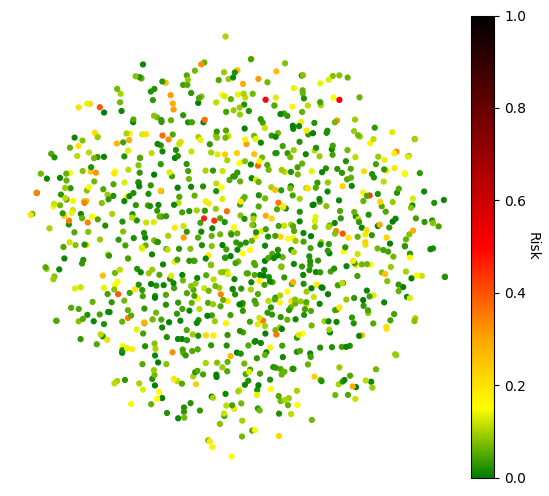

Epoch  5 | Train RMSE: 0.0818 | Val RMSE: 0.0818
Epoch 10 | Train RMSE: 0.0778 | Val RMSE: 0.0792
Epoch 15 | Train RMSE: 0.0738 | Val RMSE: 0.0760
Epoch 20 | Train RMSE: 0.0681 | Val RMSE: 0.0722
Epoch 25 | Train RMSE: 0.0645 | Val RMSE: 0.0710
Epoch 30 | Train RMSE: 0.0617 | Val RMSE: 0.0723
Epoch 35 | Train RMSE: 0.0584 | Val RMSE: 0.0708
Epoch 40 | Train RMSE: 0.0574 | Val RMSE: 0.0715
Epoch 45 | Train RMSE: 0.0550 | Val RMSE: 0.0722
Epoch 50 | Train RMSE: 0.0527 | Val RMSE: 0.0724
Epoch 55 | Train RMSE: 0.0522 | Val RMSE: 0.0719
Epoch 60 | Train RMSE: 0.0512 | Val RMSE: 0.0726
Extracted image features:
Z_train: (1000, 8) Z_test: (500, 8)


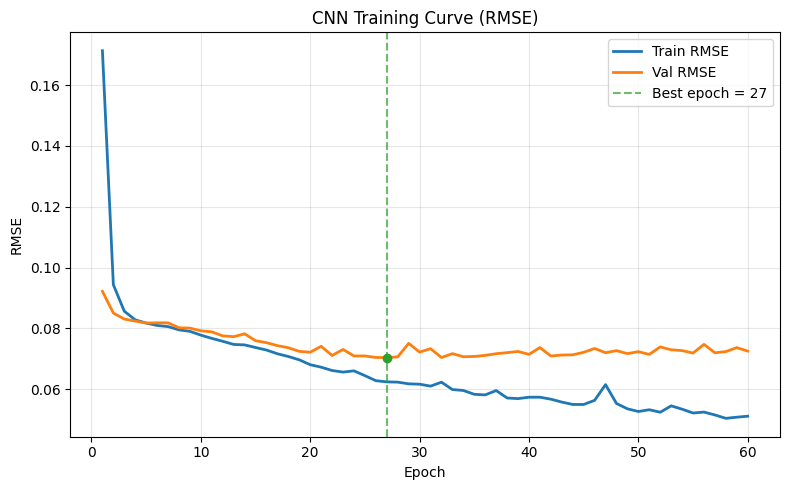

In [13]:
import os
import numpy as np

# Separate directories
IMAGE_DIR_TRAIN = "../data/data_labeled/Img_train"
IMAGE_DIR_TEST  = "../data/data_labeled/Img_test"

# 1) Sanity-check file existence and filter if needed
def existence_mask(filenames, directory):
    return np.array([os.path.exists(os.path.join(directory, f)) for f in filenames], dtype=bool)

mask_train = existence_mask(img_train, IMAGE_DIR_TRAIN)
mask_test  = existence_mask(img_test,  IMAGE_DIR_TEST)

if not mask_train.all():
    missing = np.sum(~mask_train)
    print(f"[WARN] {missing} training images listed in CSV not found in {IMAGE_DIR_TRAIN}. They will be dropped.")
    img_train = img_train[mask_train]
    y_train   = y_train[mask_train]
    X_tab_train = X_tab_train[mask_train]

if not mask_test.all():
    missing = np.sum(~mask_test)
    print(f"[WARN] {missing} test images listed in CSV not found in {IMAGE_DIR_TEST}. They will be dropped.")
    img_test = img_test[mask_test]
    y_test   = y_test[mask_test]
    X_tab_test = X_tab_test[mask_test]

print("After filtering (if any):")
print("Train sizes:", len(img_train), X_tab_train.shape, y_train.shape)
print("Test  sizes:", len(img_test),  X_tab_test.shape,  y_test.shape)

# 2) Visualize t-SNE on the official TRAIN set
dataset_viz = CustomImageDataset(
    images=img_train,
    images_directory=IMAGE_DIR_TRAIN,
    target=y_train
)
print("t-SNE on pixel values (official train set)")
visualize_dataset_tSNE(dataset_viz, extract_features=False, perplexity=30, random_state=42, zoom=2.0)

# 3) Train CNN on TRAIN images
N_FEATURES = 8
cnn = MyCNN(n_features=N_FEATURES, n_epochs=60, batch_size=50, learning_rate=5e-4)
history = cnn.fit(images=img_train, y=y_train, data_dir=IMAGE_DIR_TRAIN)

# 4) Extract features for TRAIN and TEST from their correct folders
Z_train = cnn.extract_features(images=img_train, data_dir=IMAGE_DIR_TRAIN)
Z_test  = cnn.extract_features(images=img_test,  data_dir=IMAGE_DIR_TEST)

print("Extracted image features:")
print("Z_train:", Z_train.shape, "Z_test:", Z_test.shape)

plot_cnn_training_curves(
    history,
    best_epoch=cnn.best_epoch,
    best_val_rmse=cnn.best_val_rmse,
    title="CNN Training Curve (RMSE)"
)

In [14]:
# Tabular-only baseline

rmse_tab_test = rmse_test_mlp 
print("Tabular-only MLP:")
print(f"  Test RMSE: {rmse_test_mlp:.4f}")

Tabular-only MLP:
  Test RMSE: 0.0428


t-SNE on extracted CNN features


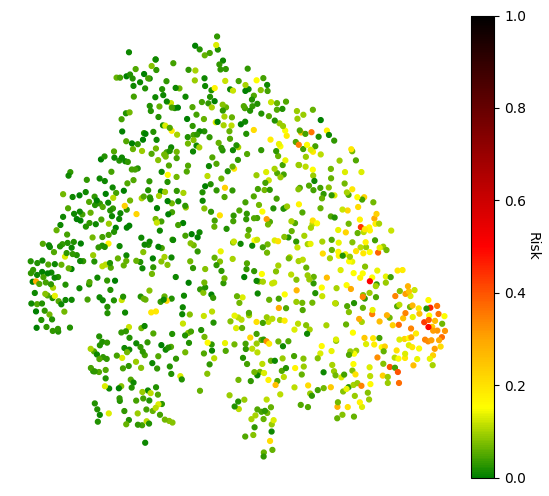

In [15]:
print("t-SNE on extracted CNN features")
visualize_dataset_tSNE(dataset_viz, extract_features=True, feature_extractor=cnn, perplexity=30, random_state=42, zoom=2.0)

Combined shapes: (1000, 16) (500, 16)



Tabular + Image MLP:
  Test RMSE: 0.0384


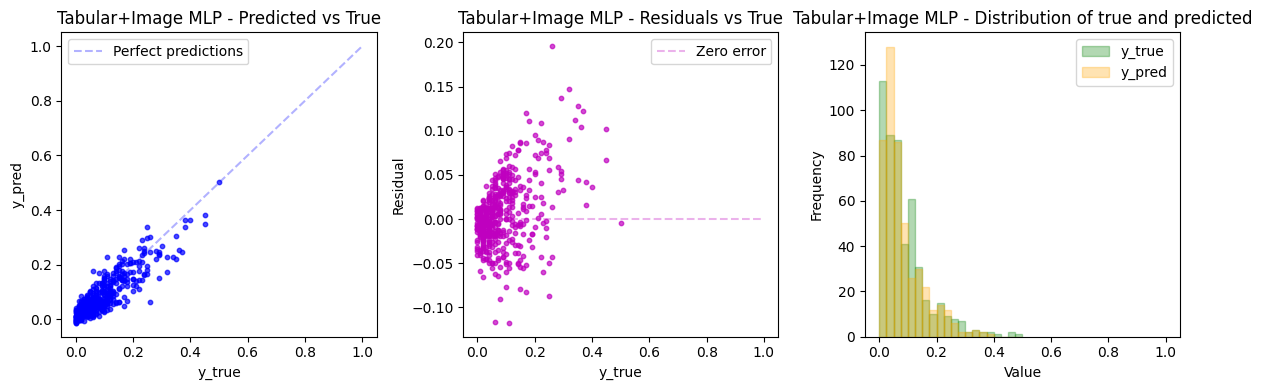

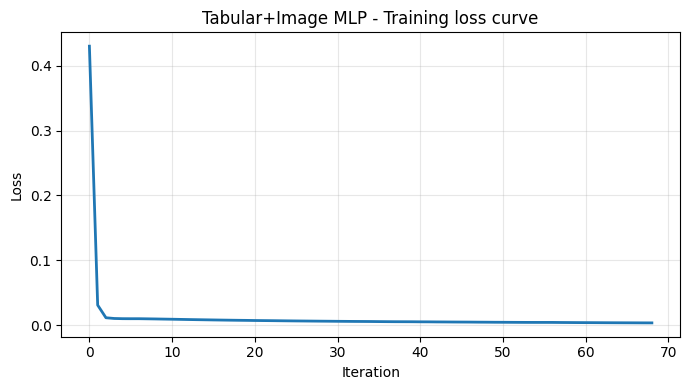

In [16]:
# Combine tabular and image features
X_comb_train = np.hstack([X_tab_train, Z_train])
X_comb_test  = np.hstack([X_tab_test,  Z_test])
print("Combined shapes:", X_comb_train.shape, X_comb_test.shape)

best_mlp_model_final.fit(X_comb_train, y_train)
y_pred_comb = best_mlp_model_final.predict(X_comb_test)
rmse_comb_test = compute_rmse(y_test, y_pred_comb)

print("\nTabular + Image MLP:")
print(f"  Test RMSE: {rmse_comb_test:.4f}")

# Residual/error analysis for combined model
visualize_regression_results(y_test, y_pred_comb, title_prefix="Tabular+Image MLP - ")

# Optional: training loss curve for the fitted MLPRegressor (after combined fit)
plot_mlp_loss_curve(best_mlp_model_final, title="Tabular+Image MLP - Training loss curve")

In [17]:
print("\n=======================================================")
print("Final Test Comparison (lower RMSE is better)")
print("-------------------------------------------------------")
print(f"Tabular-only MLP     : {rmse_tab_test:.4f}")
print(f"Tabular+Image MLP    : {rmse_comb_test:.4f}")
print("=======================================================")

improvement = rmse_tab_test - rmse_comb_test
print(f"Absolute improvement (RMSE): {improvement:+.4f}")


Final Test Comparison (lower RMSE is better)
-------------------------------------------------------
Tabular-only MLP     : 0.0428
Tabular+Image MLP    : 0.0384
Absolute improvement (RMSE): +0.0044


Baseline Tabular+Image RMSE: 0.0384

Tabular+Image+blur_soft RMSE: 0.0394  (Δ vs baseline: -0.0010)
Tabular+Image+sharpen RMSE: 0.0483  (Δ vs baseline: -0.0099)
Tabular+Image+laplacian_4 RMSE: 0.0459  (Δ vs baseline: -0.0075)
Tabular+Image+laplacian_8 RMSE: 0.0422  (Δ vs baseline: -0.0038)
Tabular+Image+sobel_x RMSE: 0.0429  (Δ vs baseline: -0.0045)
Tabular+Image+sobel_y RMSE: 0.0468  (Δ vs baseline: -0.0084)
Tabular+Image+scharr_x RMSE: 0.0421  (Δ vs baseline: -0.0037)
Tabular+Image+scharr_y RMSE: 0.0468  (Δ vs baseline: -0.0084)
Tabular+Image+emboss RMSE: 0.0403  (Δ vs baseline: -0.0019)

=== Summary (lower is better) ===
blur_soft    -> RMSE: 0.0394 (Δ vs baseline: -0.0010)
emboss       -> RMSE: 0.0403 (Δ vs baseline: -0.0019)
scharr_x     -> RMSE: 0.0421 (Δ vs baseline: -0.0037)
laplacian_8  -> RMSE: 0.0422 (Δ vs baseline: -0.0038)
sobel_x      -> RMSE: 0.0429 (Δ vs baseline: -0.0045)
laplacian_4  -> RMSE: 0.0459 (Δ vs baseline: -0.0075)
scharr_y     -> RMSE: 0.0468 (Δ vs baseline:

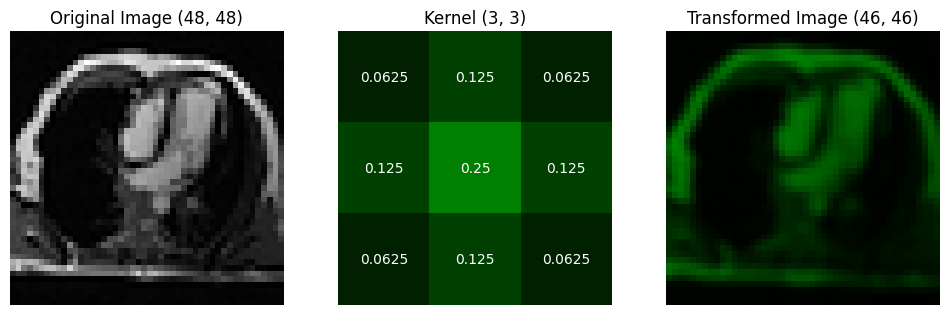


Tabular + Image + BEST Kernel MLP:
  BEST KERNEL: blur_soft
  Test RMSE:   0.0394


In [18]:


# 0) (Optional) Extract all engineered features once (with unsharp/DoG) for inspection
kernel_train_feats, kernel_feature_names = extract_engineered_kernel_features(
    img_train, IMAGE_DIR_TRAIN, KERNEL_BANK,
    include_unsharp=True,
    include_dog=True,
    dog_params=(1.0, 2.5),
    unsharp_alpha=1.2
)
kernel_test_feats, _ = extract_engineered_kernel_features(
    img_test, IMAGE_DIR_TEST, KERNEL_BANK,
    include_unsharp=True,
    include_dog=True,
    dog_params=(1.0, 2.5),
    unsharp_alpha=1.2
)

# 1) Evaluate each kernel separately (train/test use their own folders)
kernel_rmse_results = []

print(f"Baseline Tabular+Image RMSE: {rmse_comb_test:.4f}\n")

for kname, kmat in KERNEL_BANK.items():
    # Extract stats for this kernel only (no unsharp/DoG) from the correct folders
    feats_train, _ = extract_engineered_kernel_features(
        img_train, IMAGE_DIR_TRAIN, {kname: kmat},
        include_unsharp=False, include_dog=False
    )
    feats_test, _ = extract_engineered_kernel_features(
        img_test, IMAGE_DIR_TEST, {kname: kmat},
        include_unsharp=False, include_dog=False
    )

    # Augment the combined (tabular + CNN) features
    X_single_train = np.hstack([X_comb_train, feats_train])
    X_single_test  = np.hstack([X_comb_test,  feats_test])

    # Fit a fresh MLP clone and compute test RMSE
    model = clone(best_mlp_model_final)
    model.set_params(mlp__max_iter=2000)
    model.fit(X_single_train, y_train)
    y_pred_single = model.predict(X_single_test)
    r = compute_rmse(y_pred_single, y_test)

    kernel_rmse_results.append((kname, r))
    print(f"Tabular+Image+{kname} RMSE: {r:.4f}  (Δ vs baseline: {rmse_comb_test - r:+.4f})")

# 2) Sort, select best, and print summary
kernel_rmse_results = sorted(kernel_rmse_results, key=lambda x: x[1])
print("\n=== Summary (lower is better) ===")
for name, r in kernel_rmse_results:
    print(f"{name:12s} -> RMSE: {r:.4f} (Δ vs baseline: {rmse_comb_test - r:+.4f})")

best_kernel_name, best_kernel_rmse = kernel_rmse_results[0]
BEST_KERNEL_NAME = best_kernel_name
BEST_KERNEL_MATRIX = KERNEL_BANK[best_kernel_name]
print(f"\n>>> BEST KERNEL: {BEST_KERNEL_NAME} (RMSE = {best_kernel_rmse:.4f})")

# 3) Visualize ONLY the best kernel convolution on a sample TRAIN image
# Make sure dataset_viz points to train dir; recreate if not in scope
try:
    _ = dataset_viz
except NameError:
    dataset_viz = CustomImageDataset(
        images=img_train,
        images_directory=IMAGE_DIR_TRAIN,
        target=y_train
    )
sample_idx = 20
sample_image, _ = dataset_viz[sample_idx]  # torch tensor (1,H,W)
visualize_2Dconvolution(sample_image.clone(), BEST_KERNEL_MATRIX)

# 4) Build engineered features with ONLY the best kernel and update augmented sets (using correct folders)
best_train_feats, best_feat_names = extract_engineered_kernel_features(
    img_train, IMAGE_DIR_TRAIN, {BEST_KERNEL_NAME: BEST_KERNEL_MATRIX},
    include_unsharp=False, include_dog=False
)
best_test_feats, _ = extract_engineered_kernel_features(
    img_test, IMAGE_DIR_TEST, {BEST_KERNEL_NAME: BEST_KERNEL_MATRIX},
    include_unsharp=False, include_dog=False
)

X_aug_train = np.hstack([X_comb_train, best_train_feats])
X_aug_test  = np.hstack([X_comb_test,  best_test_feats])

# 5) Fit an augmented MLP using only the best kernel features
augmented_mlp = clone(best_mlp_model_final)
augmented_mlp.set_params(mlp__max_iter=2000)
augmented_mlp.fit(X_aug_train, y_train)
y_pred_aug = augmented_mlp.predict(X_aug_test)
rmse_aug_test = compute_rmse(y_pred_aug, y_test)

print("\nTabular + Image + BEST Kernel MLP:")
print(f"  BEST KERNEL: {BEST_KERNEL_NAME}")
print(f"  Test RMSE:   {rmse_aug_test:.4f}")

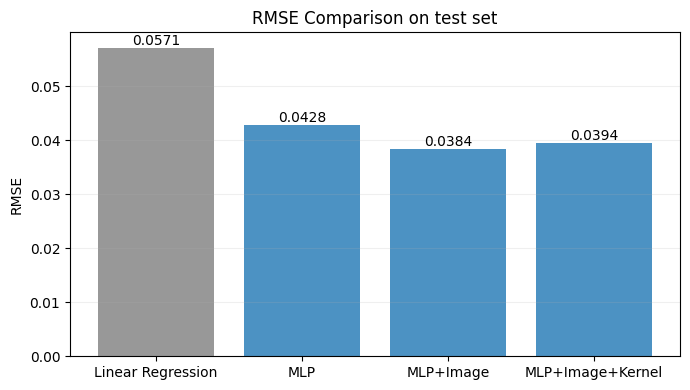

Absolute improvement MLP + Image + Kernel vs MLP: +0.0034
Absolute improvement MLP + Image + Kernel vs MLP + Image: -0.0010


In [19]:
plot_rmse_comparison(
    {   
        "Linear Regression": rmse_test_linear,
        "MLP": rmse_tab_test,
        "MLP+Image": rmse_comb_test,
        "MLP+Image+Kernel": rmse_aug_test
    },
    title="RMSE Comparison on test set"
)

print("Absolute improvement MLP + Image + Kernel vs MLP:",
      f"{rmse_tab_test - rmse_aug_test:+.4f}")
print("Absolute improvement MLP + Image + Kernel vs MLP + Image:",
      f"{rmse_comb_test - rmse_aug_test:+.4f}")

In [20]:
# Final cell — Produce y_pred.csv for unlabeled X.csv using best Tabular+Image model (no kernel)

import os
import numpy as np
import pandas as pd

# Columns used for tabular part (same as training)
cols = [
    'blood pressure', 'cholesterol', 'weight', 'potassium',
    'sarsaparilla', 'vitamin D', 'age', 'hemoglobin'
]

# 1) Build tabular matrix for unlabeled with the same columns and order
X_unlabeled_aligned = X_unlabeled.copy()
missing_cols = [c for c in cols if c not in X_unlabeled_aligned.columns]
if missing_cols:
    raise ValueError(f"Unlabeled dataframe is missing required columns: {missing_cols}")
X_tab_unlabeled = X_unlabeled_aligned[cols].values

# 2) Unlabeled image filenames and directory
img_unlabeled = X_unlabeled_aligned['img_filename'].astype(str).values
IMAGE_DIR_UNLABELED = "../data/data_unlabeled/Img"

# Optional: filter out rows with missing image files to keep arrays aligned
def exists_mask(filenames, directory):
    return np.array([os.path.exists(os.path.join(directory, f)) for f in filenames], dtype=bool)

mask_unl = exists_mask(img_unlabeled, IMAGE_DIR_UNLABELED)
if not mask_unl.all():
    missing = np.sum(~mask_unl)
    print(f"[WARN] {missing} unlabeled images not found in {IMAGE_DIR_UNLABELED}. Dropping those rows.")
    img_unlabeled   = img_unlabeled[mask_unl]
    X_tab_unlabeled = X_tab_unlabeled[mask_unl]

print("Unlabeled inputs:", X_tab_unlabeled.shape, "images:", len(img_unlabeled))

# 3) Extract CNN features for unlabeled images using the trained CNN from Part 3
Z_unlabeled = cnn.extract_features(images=img_unlabeled, data_dir=IMAGE_DIR_UNLABELED)
print("Z_unlabeled shape:", Z_unlabeled.shape)

# 4) Combine tabular and image features
X_comb_unlabeled = np.hstack([X_tab_unlabeled, Z_unlabeled])
print("X_comb_unlabeled:", X_comb_unlabeled.shape)

# 5) Predict with the best MLP model (already fitted on X_comb_train, y_train)
y_pred_unlabeled = best_mlp_model_final.predict(X_comb_unlabeled)

# 6) Save to y_pred.csv (as required by the assignment)
out_df = pd.DataFrame({"y_pred": y_pred_unlabeled})
out_path = "y_pred.csv"  # exact filename requested
out_df.to_csv(out_path, index=False, header=False)
print(f"Saved predictions to: {out_path}")

Unlabeled inputs: (500, 8) images: 500
Z_unlabeled shape: (500, 8)
X_comb_unlabeled: (500, 16)
Saved predictions to: y_pred.csv
